In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [7]:
res_1_df = pd.read_csv('results_1.1.csv')

In [8]:
res_1_df.head()

,degree,threads,time_alloc,time_init,time_seq_baseline,time_thread_create,time_compute,time_thread_join,time_cleanup,time_total,verification,user
0,5000,sequential,0.000019,0.000127,0.036079,0.000000,0.000000,0.000000,0.000002,0.036227,PASS,marr
1,5000,1,0.000045,0.000125,0.087195,0.003081,0.046658,0.000010,0.000001,0.137116,PASS,marr
2,5000,2,0.000054,0.004769,0.039323,0.006115,0.036593,0.000021,0.000001,0.086877,PASS,marr
3,5000,4,0.000072,0.000124,0.055157,0.016878,0.008797,0.000030,0.000001,0.081061,PASS,marr
4,5000,8,0.000102,0.000125,0.008544,0.000319,0.021859,0.000055,0.000002,0.031007,PASS,marr


In [9]:
os.makedirs('plots', exist_ok=True)

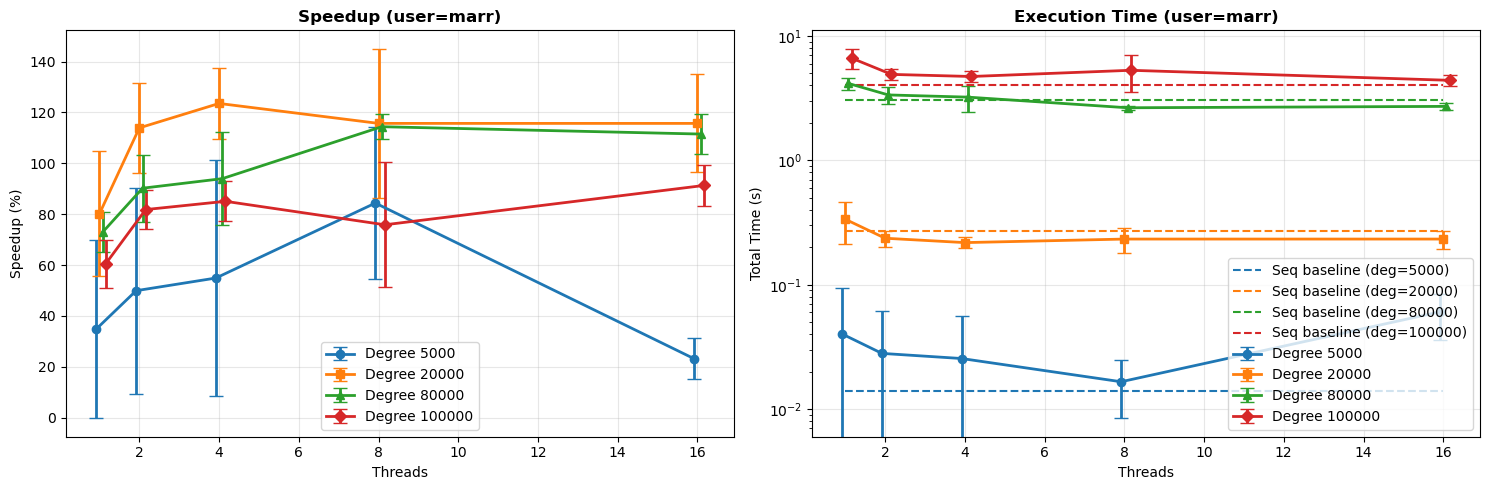

In [10]:
# -----------------------------------------------------------
# CLEAN LOAD + CLEAN THREAD HANDLING
# -----------------------------------------------------------

# threads may contain numbers or the text "sequential"
res_1_df['threads'] = res_1_df['threads'].astype(str)

# Create a clean numeric thread column (parallel only)
# sequential gets NaN here (so it will be excluded from x-axis plots)
res_1_df['threads_num'] = pd.to_numeric(res_1_df['threads'], errors='coerce')

# -----------------------------------------------------------
# BUILD PURE SEQUENTIAL BASELINE TABLE
# -----------------------------------------------------------

seq_baseline = (
    res_1_df[res_1_df['threads'] == 'sequential']
    .groupby(['user', 'degree'], as_index=False)
    .agg(
        seq_time_mean=('time_total', 'mean'),
        seq_time_std=('time_total', 'std'),
    )
)

# merge baseline into full DF (parallel rows get correct baseline)
df = res_1_df.merge(seq_baseline, on=['user', 'degree'], how='left')

# -----------------------------------------------------------
# COMPUTE SPEEDUP + AGGREGATE STATS
# -----------------------------------------------------------

# keep a per-run speedup value (seq_mean / run_time) so we can estimate spread
df['speedup'] = df['seq_time_mean'] / df['time_total']

# aggregate primary statistics (mean of times)
grouped = df.groupby(['user', 'degree', 'threads'], as_index=False).agg(
    time_total_mean=('time_total', 'mean'),
    time_total_std=('time_total', 'std'),
    seq_time_mean=('seq_time_mean', 'mean'),
    seq_time_std=('seq_time_std', 'mean'),
)

# compute speedup as ratio of means (preferred estimator): seq_mean / par_mean
grouped['speedup_mean'] = grouped['seq_time_mean'] / grouped['time_total_mean']

# compute speedup std from per-run speedup values (preserves variability info)
speedup_std = (
    df.groupby(['user', 'degree', 'threads'], as_index=False)
    .agg(speedup_std=('speedup', 'std'))
)
grouped = grouped.merge(speedup_std, on=['user', 'degree', 'threads'], how='left')
grouped['speedup_std'] = grouped['speedup_std'].fillna(0.0)

# add numeric version again for plotting
grouped['threads_num'] = pd.to_numeric(grouped['threads'], errors='coerce')

users = sorted(df['user'].unique())

# -----------------------------------------------------------
# CONFIG
# -----------------------------------------------------------

MARKERS = ["o", "s", "^", "D", "v", "P", "*", "X"]
LINESTYLES = ["-", "-", "-"]
COLORS = plt.cm.tab10.colors

def tiny_jitter(index, scale=0.08):
    return (index - 1) * scale

# -----------------------------------------------------------
# PLOTTING FUNCTION
# -----------------------------------------------------------

def plot_user(user, grouped):

    # filter for this user
    user_group = grouped[grouped['user'] == user]
    degrees = sorted(user_group['degree'].unique())

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # -------------------------------------------------------
    # SPEEDUP PLOT
    # -------------------------------------------------------

    for di, degree in enumerate(degrees):
        deg_grp = user_group[user_group['degree'] == degree].copy()

        # exclude sequential rows (threads_num is NaN)
        deg_grp = deg_grp.dropna(subset=['threads_num']).sort_values('threads_num')
        if deg_grp.empty:
            continue

        x = deg_grp['threads_num'] + tiny_jitter(di)
        y = 100.0 * deg_grp['speedup_mean']
        yerr = 100.0 * deg_grp['speedup_std'].fillna(0)

        axes[0].errorbar(
            x, y, yerr=yerr,
            color=COLORS[di % len(COLORS)],
            marker=MARKERS[di % len(MARKERS)],
            linestyle=LINESTYLES[di % len(LINESTYLES)],
            linewidth=2, markersize=6, capsize=5,
            label=f"Degree {degree}",
        )

    axes[0].set_title(f"Speedup (user={user})", fontsize=12, fontweight="bold")
    axes[0].set_xlabel("Threads")
    axes[0].set_ylabel("Speedup (%)")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # -------------------------------------------------------
    # EXECUTION TIME PLOT
    # -------------------------------------------------------

    for di, degree in enumerate(degrees):
        deg_grp = user_group[user_group['degree'] == degree].copy()

        # sequential baseline
        seq_row = deg_grp[deg_grp['threads'] == 'sequential']
        if seq_row.empty:
            continue

        seq_time = seq_row['time_total_mean'].iloc[0]

        # parallel rows only
        par_grp = deg_grp.dropna(subset=['threads_num']).sort_values('threads_num')
        if par_grp.empty:
            continue

        x = par_grp['threads_num'] + tiny_jitter(di)
        y = par_grp['time_total_mean']
        yerr = par_grp['time_total_std'].fillna(0.0)

        line = axes[1].errorbar(
            x, y, yerr=yerr,
            color=COLORS[di % len(COLORS)],
            marker=MARKERS[di % len(MARKERS)],
            linestyle=LINESTYLES[di % len(LINESTYLES)],
            linewidth=2, markersize=6, capsize=5,
            label=f"Degree {degree}",
        )

        # sequential baseline line
        color = line[0].get_color()
        xmin = par_grp['threads_num'].min()
        xmax = par_grp['threads_num'].max()

        axes[1].hlines(seq_time, xmin, xmax, linestyles='--', colors=color, linewidth=1.5)
        axes[1].plot([], [], linestyle='--', color=color, label=f"Seq baseline (deg={degree})")

    axes[1].set_title(f"Execution Time (user={user})", fontsize=12, fontweight="bold")
    axes[1].set_xlabel("Threads")
    axes[1].set_ylabel("Total Time (s)")
    axes[1].set_yscale("log")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(os.path.join("plots", f"results_1_1_graph_{user}.png"))
    plt.show()


# -----------------------------------------------------------
# RUN PLOTTER FOR EACH USER
# -----------------------------------------------------------

for user in users:
    plot_user(user, grouped)